In [27]:
import sys,array
from ROOT import TFile, TCanvas
import root_numpy as rn
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca

%matplotlib inline
font = 22

matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rc('font',family='serif')
matplotlib.rc('font',weight='bold')
matplotlib.rc('font',size=font)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

In [28]:
f = rn.root2array('../Files/pi0_smear_getrandom_ana_fix.root', treename='pi0_selection')
dfs_w_smear_getrandom = pd.DataFrame(f)

f = rn.root2array('../Files/pi0_cosmic_smear_getrandom_ana.root', treename='pi0_selection')
dfs_ccpi0_w_smear = pd.DataFrame(f)

In [29]:
#name = 'singleshower'
name = 'pi0'
stage = 'pi0'

f = '/Volumes/UBooNEDataMCC8/MCC8_3/AnaFiles/MCBNBCos/BT_backgrounds_%s.root'%stage
on ='/Volumes/UBooNEDataMCC8/MCC8_3/AnaFiles/OnBeam/BT_backgrounds_%s.root'%stage
off='/Volumes/UBooNEDataMCC8/MCC8_3/AnaFiles/OffBeam/BT_backgrounds_%s.root'%stage

t = rn.root2array(f,treename='tree')
df = pd.DataFrame(t)
df = df.query('(pi0_low_shrE > 40 | pi0_high_shrE > 40) & (pi0_low_radL < 100 & pi0_high_radL < 80)')

a = rn.root2array(on,treename='tree')
df0 = pd.DataFrame(a)
df0 = df0.query('(pi0_low_shrE > 40 | pi0_high_shrE > 40) & (pi0_low_radL < 100 & pi0_high_radL < 80)')

b = rn.root2array(off,treename='tree')
df1 = pd.DataFrame(b)
df1 = df1.query('(pi0_low_shrE > 40 | pi0_high_shrE > 40) & (pi0_low_radL < 100 & pi0_high_radL < 80)')


stage = 'pi0signalonly'

In [30]:
#print df0.shape, df1.shape, df.shape
#print df.info()
#print df.gamma_RL.values

In [31]:
all_but_sig_v = df.query('bkgd_id != 2')

dfa = df.query('pi0_low_origin != 2 and pi0_high_origin != 2')

cos_v = df.query('bkgd_id == 1 or pi0_low_origin == 2 or pi0_high_origin == 2')
cc1pi0_v = dfa.query('bkgd_id == 2')
nc1pi0_v = dfa.query('bkgd_id == 3')
multpi0_v = dfa.query('bkgd_id == 5')
cccex_v = dfa.query('bkgd_id == 8 ')
nu_EM_v = dfa.query('bkgd_id == 10 or ((bkgd_id ==12 or bkgd_id ==11) &\
                   (pi0_low_type == 1 or pi0_high_type == 1) )')

oth_v = dfa.query('bkgd_id == 0 or bkgd_id == 4 or\
                  bkgd_id == 6 or bkgd_id == 7 or bkgd_id == 9 or bkgd_id == 13 or \
                  ((bkgd_id ==12 or bkgd_id ==11) & pi0_low_type != 1 & pi0_high_type != 1)')

allbut_v = df.query('bkgd_id != 2 or pi0_low_origin == 2 or pi0_high_origin == 2')

print allbut_v.shape[0] + cc1pi0_v.shape[0]
print cos_v.shape[0] + cc1pi0_v.shape[0] + nc1pi0_v.shape[0] + multpi0_v.shape[0] + \
          cccex_v.shape[0] + nu_EM_v.shape[0] + oth_v.shape[0]  #+ no_EM_v.shape[0]

633
633


In [32]:
#print cos_v.shape[0]
print float(cos_v.shape[0])/df.shape[0]

0.0631911532385


In [33]:
from scipy.optimize import curve_fit

def exp(x, *p):
    A, c, d = p
    return A*np.exp(-c*x) + d
    

In [34]:
dataPOT = 0.492
mcbnbcos_POT = 4.23214
off_to_on = 2.168404449
mc_to_onbeam = dataPOT/mcbnbcos_POT

print "POTS : ", dataPOT, mcbnbcos_POT 
print "MC to OnBeam : ", mc_to_onbeam
print "Off to OnBeam: ",off_to_on

POTS :  0.492 4.23214
MC to OnBeam :  0.11625324304
Off to OnBeam:  2.168404449


In [35]:
def makeOnOffPlots(var,xmin,xmax,nbins=20,xlabel='',includepot=False,unit='cm'):

    x_on, y_on = np.histogram(df0[var].values,bins=nbins,range=(xmin,xmax))
    x_off, y_off = np.histogram(df1[var].values,bins=nbins,range=(xmin,xmax))
    x_mc_sig, y_mc_sig = np.histogram(cc1pi0_v[var].values,bins=nbins,range=(xmin,xmax))
    x_mc_bkgd, y_mc_bkgd = np.histogram(all_but_sig_v[var].values,bins=nbins,range=(xmin,xmax))
    
    bins = (y_off[:-1] + y_off[1:])/2
    bin_width = bins[1]-bins[0]

    bnbcos_sig     = x_mc_sig * mc_to_onbeam 
    on_min_off_mc  = x_on - x_off * off_to_on - x_mc_bkgd * mc_to_onbeam
    
    err_mc_sig = np.sqrt(x_mc_sig) * mc_to_onbeam
    err_on = np.sqrt(x_on)
    err_off = np.sqrt(x_off) * off_to_on
    err_mc_bkgd = np.sqrt(x_mc_bkgd) * mc_to_onbeam
    err_on_off_mc = np.sqrt(err_on*err_on + err_off*err_off + err_mc_bkgd*err_mc_bkgd)
    
    lgd = 0
    
    labels_tst = ['$\\nu_{\mu}$ CC 1 $\pi^0$']; colors_tst = ['salmon'] 
    sig_w = [ mc_to_onbeam for i in xrange(len(cc1pi0_v[var].values)) ] 

    bar_bin_width = [nbins[i+1] - nbins[i] for i in xrange(len(nbins)-1) ]
    bar_bins = [(nbins[i+1] + nbins[i])/2 - (bar_bin_width[i])/2 for i in xrange(len(nbins)-1) ]
    new_weight = [ 1. / bar_bin_width[i] for i in xrange(len(bar_bin_width))]
    data_bar_bin_width = [(nbins[i+1] - nbins[i])/2 for i in xrange(len(nbins)-1) ]

    df_v = [cc1pi0_v] ; weights = [sig_w]
    
    for i in xrange(len(weights)):
        w = weights[i]
        for j in xrange(len(w)):
            if df_v[i].pi0_mass.values[j] < bins[1] :
                w[j] *= (1./(nbins[1]-nbins[0]))
            elif df_v[i].pi0_mass.values[j] >= nbins[1] and df_v[i].pi0_mass.values[j] < nbins[2]:
                w[j] *= (1./(nbins[2]-nbins[1]))
            elif df_v[i].pi0_mass.values[j] >= nbins[2] and df_v[i].pi0_mass.values[j] < nbins[3]:
                w[j] *= (1./(nbins[3]-nbins[2]))
            elif df_v[i].pi0_mass.values[j] >= nbins[3] and df_v[i].pi0_mass.values[j] < nbins[4]:
                w[j] *= (1./(nbins[4]-nbins[3]))
            elif df_v[i].pi0_mass.values[j] >= nbins[4] and df_v[i].pi0_mass.values[j] < nbins[5]:
                w[j] *= (1./(nbins[5]-nbins[4]))
            elif df_v[i].pi0_mass.values[j] >= nbins[5] and df_v[i].pi0_mass.values[j] < nbins[6]:
                w[j] *= (1./(nbins[6]-nbins[5]))
            elif df_v[i].pi0_mass.values[j] >= nbins[6] and df_v[i].pi0_mass.values[j] < nbins[7]:
                w[j] *= (1./(nbins[7]-nbins[6]))
            elif df_v[i].pi0_mass.values[j] >= nbins[7] and df_v[i].pi0_mass.values[j] < nbins[8]:
                w[j] *= (1./(nbins[8]-nbins[7]))
      
    font = 22
    fig,ax = plt.subplots(figsize=(8,6))

    out = ax.hist([cc1pi0_v[var].values],bins=nbins,label=labels_tst,color=colors_tst,ec='None',\
        range=(xmin,xmax),weights=weights,rwidth=bin_width,histtype='stepfilled')
    plt.bar(bar_bins,(err_mc_sig*2)*new_weight,width=bar_bin_width,bottom = (bnbcos_sig - err_mc_sig)*new_weight,\
        alpha=.5,  fill=False, linewidth=0,hatch='\\\\\\\\')
    plt.errorbar(bins,on_min_off_mc*new_weight,xerr=data_bar_bin_width,yerr=err_on_off_mc*new_weight,fmt='ko',label='Data - Backgrounds',markersize=6,lw=1.5)

    plt.ylabel('(Data - Backgrounds) / %s '%(unit),fontsize=font,weight='bold') 
    
    spi0_w_smear_getrandom_w = [0.000171 for i in xrange(len(dfs_w_smear_getrandom._pi0_mass.values))]
    ccpi0_w_smear_w = [ 0.000173 for i in xrange(len(dfs_ccpi0_w_smear._pi0_mass.values)) ]

    _,_,_ = plt.hist(dfs_w_smear_getrandom._pi0_mass.values,bins=nbins,range=(xmin,xmax),color='g',ls='-',lw=2,weights=spi0_w_smear_getrandom_w,histtype='step',label='Single $\pi^0$ (w/o Cos)')
    _,_,_ = plt.hist(dfs_ccpi0_w_smear._pi0_mass.values,bins=nbins,range=(xmin,xmax),color='b',ls='-',lw=2,weights=ccpi0_w_smear_w,histtype='step',label='Single $\pi^0$ (w/ Cos)')
    
    handles,labels = ax.get_legend_handles_labels()
    lgd = plt.legend(handles=handles,fontsize=18,loc=0) #loc='upper left',bbox_to_anchor=(1,1))
    lgd._legend_box.align = "left"
    plt.xticks([0,100,200,300,400],weight='bold')
    
    plt.xlabel(xlabel,fontsize=font,weight='bold')
    plt.text(0.7,1.01,r'4.92 \textbf{$\times 10^{19}$} POT',weight='bold',color='r',fontsize=18,transform = ax.transAxes)
    plt.text(0.01,1.005,r'MicroBooNE Preliminary',weight='bold',color='r',fontsize=18,transform = ax.transAxes)

    plt.grid(True)
    plt.xlim(xmin,xmax)
    plt.ylim(0)

    plt.savefig('Plots/Paper_%s_onoffseparate_%s.png'%(stage,var),bbox_extra_artists=(lgd,), bbox_inches='tight')

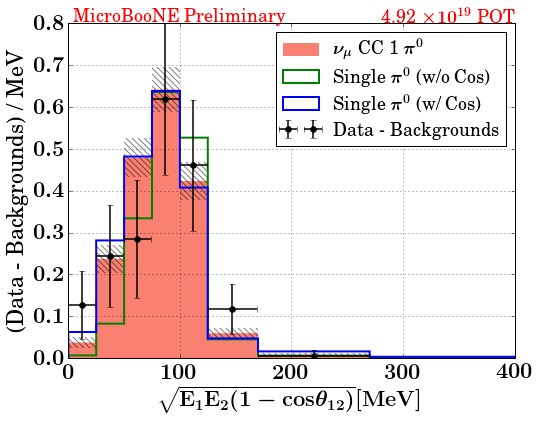

In [36]:
bins=[0,25,50,75,100,125,170,270,400]
makeOnOffPlots('pi0_mass',0,400,nbins=bins,xlabel=r'$\mathrm{\sqrt{E_1 E_2 (1-cos\theta_{12})} [MeV]}$',unit='MeV')

In [37]:
def makeRLPlots(var,var2,xmin,xmax,nbins=20,xlabel='',pottitle='4.92e19 POT',unit='cm'):

    new_on = np.concatenate((df0[var].values,df0[var2].values),axis=0)
    new_off = np.concatenate((df1[var].values,df1[var2].values),axis=0)
    new_mc = np.concatenate((df[var].values,df[var2].values),axis=0)
    new_cc1pi0 = np.concatenate((cc1pi0_v[var].values,cc1pi0_v[var2].values),axis=0)
    new_allbut = np.concatenate((allbut_v[var].values,allbut_v[var2].values),axis=0)
    
    x_on, y_on = np.histogram(new_on,bins=nbins,range=(xmin,xmax))
    x_off, y_off = np.histogram(new_off,bins=nbins,range=(xmin,xmax))
    x_bnb, y_bnb = np.histogram(new_mc,bins=nbins,range=(xmin,xmax))
    x_mc_sig, y_mc_sig = np.histogram(new_cc1pi0,bins=nbins,range=(xmin,xmax))
    x_mc_bkgd, y_mc_bkgd = np.histogram(new_allbut,bins=nbins,range=(xmin,xmax))
    
    bins = (y_off[:-1] + y_off[1:])/2
    bin_width = bins[1]-bins[0]
         
    bnbcos_sig     = x_mc_sig * mc_to_onbeam 
    on_min_off_mc  = x_on - x_off * off_to_on - x_mc_bkgd * mc_to_onbeam
    
    err_mc_sig = np.sqrt(x_mc_sig) * mc_to_onbeam
    err_on = np.sqrt(x_on)
    err_off = np.sqrt(x_off) * off_to_on
    err_mc_bkgd = np.sqrt(x_mc_bkgd) * mc_to_onbeam
    err_on_off_mc = np.sqrt(err_on*err_on + err_off*err_off + err_mc_bkgd*err_mc_bkgd)


    sig_w = [ mc_to_onbeam for i in xrange(len(cc1pi0_v[var].values)+len(cc1pi0_v[var2].values) ) ] 
    
    df_v = [new_cc1pi0]
    weights = [sig_w]
    
    for i in xrange(len(weights)):
        w = weights[i]
        for j in xrange(len(w)):
            if df_v[i][j] < bins[1] :
                w[j] *= (1./(nbins[1]-nbins[0]))
            elif df_v[i][j] >= nbins[1] and df_v[i][j] < nbins[2]:
                w[j] *= (1./(nbins[2]-nbins[1]))
            elif df_v[i][j] >= nbins[2] and df_v[i][j] < nbins[3]:
                w[j] *= (1./(nbins[3]-nbins[2]))
            elif df_v[i][j] >= nbins[3] and df_v[i][j] < nbins[4]:
                w[j] *= (1./(nbins[4]-nbins[3]))
            elif df_v[i][j] >= nbins[4] and df_v[i][j] < nbins[5]:
                w[j] *= (1./(nbins[5]-nbins[4]))
            elif df_v[i][j] >= nbins[5] and df_v[i][j] < nbins[6]:
                w[j] *= (1./(nbins[6]-nbins[5]))
            elif df_v[i][j] >= nbins[6] and df_v[i][j] < nbins[7]:
                w[j] *= (1./(nbins[7]-nbins[6]))
            elif df_v[i][j] >= nbins[7] and df_v[i][j] < nbins[8]:
                w[j] *= (1./(nbins[8]-nbins[7]))
            elif df_v[i][j] >= nbins[8] and df_v[i][j] < nbins[9]:
                w[j] *= (1./(nbins[9]-nbins[8]))
            elif df_v[i][j] >= nbins[9] and df_v[i][j] < nbins[10]:
                w[j] *= (1./(nbins[10]-nbins[9]))
            #elif df_v[i][j] >= nbins[10] and df_v[i][j] < nbins[11]:
            #    w[j] *= (1./(nbins[11]-nbins[10]))
              
    lgd = 0
    labels_tst = ['$\\nu_{\mu}$ CC 1 $\pi^0$']; colors_tst = ['salmon'] 

    fig,ax = plt.subplots(figsize=(8,6))
    
    bar_bin_width = [nbins[i+1] - nbins[i] for i in xrange(len(nbins)-1) ]
    bar_bins = [(nbins[i+1] + nbins[i])/2 - (bar_bin_width[i])/2 for i in xrange(len(nbins)-1) ]
    
    data_bar_bin_width = [(nbins[i+1] - nbins[i])/2 for i in xrange(len(nbins)-1) ]

    new_weight = [ 1. / bar_bin_width[i] for i in xrange(len(bar_bin_width))]
    
    
    out = ax.hist([new_cc1pi0],bins=nbins,label=labels_tst,color=colors_tst,ec='None',\
        range=(xmin,xmax),weights=weights,rwidth=bin_width,histtype='stepfilled')
    plt.bar(bar_bins,(err_mc_sig*2)*new_weight,width=bar_bin_width,bottom = (bnbcos_sig - err_mc_sig)*new_weight,\
        alpha=.5,  fill=False, linewidth=0,hatch='\\\\\\\\')
    plt.errorbar(bins,on_min_off_mc*new_weight,xerr=data_bar_bin_width,yerr=err_on_off_mc*new_weight,fmt='ko',label='Data - Backgrounds',markersize=6,lw=1.5)
    
    if var == 'pi0_low_radL':
        # Calculate EXP distribution
        x_g = np.linspace(xmin,xmax,200)

        bins = (out[1][:-1] + out[1][1:])/2
        coeff, pcov = curve_fit(exp, bins, out[0], p0=([12.,.05,0.]))
        onesigma = np.sqrt(np.diag(pcov))
        #plt.plot(x_g, exp(x_g,*coeff), 'g--',label='MC Conv Dist: %i $\pm$ %i'%\
        #        ((1./coeff[1]),(1./coeff[1]**2*onesigma[1])),lw=2)

        x_g = np.linspace(xmin,xmax,200)
        coeff, pcov = curve_fit(exp, bins, on_min_off_mc*new_weight, p0=([12.,.05,0.]))
        onesigma = np.sqrt(np.diag(pcov))
        plt.plot(x_g, exp(x_g,*coeff), 'b-',label='Data Conv Dist: %i $\pm$ %i'%\
                 ((1./coeff[1]),(1./coeff[1]**2*onesigma[1])),lw=2)

    handles,labels = ax.get_legend_handles_labels()
    font = 22    
    lgd = plt.legend(handles=handles,fontsize=20,loc=0) #loc='upper left',bbox_to_anchor=(1,1))
   
    plt.grid(True)
    plt.xlabel(xlabel,fontsize=font,weight='bold')
    plt.xticks(weight='bold')
    plt.ylim(0.001)
    plt.ylabel('(Data - Backgrounds) / %s '%(unit),fontsize=font,weight='bold') 
    
    plt.text(0.7,1.01,r'4.92 \textbf{$\times 10^{19}$} POT',weight='bold',color='r',fontsize=18,transform = ax.transAxes)
    plt.text(0.01,1.005,r'MicroBooNE Preliminary',weight='bold',color='r',fontsize=18,transform = ax.transAxes)

    plt.xlim(xmin,xmax)
    plt.savefig('Plots/Paper_%s_onoffseparate_%s.png'%(stage,var),bbox_extra_artists=(lgd,), bbox_inches='tight')

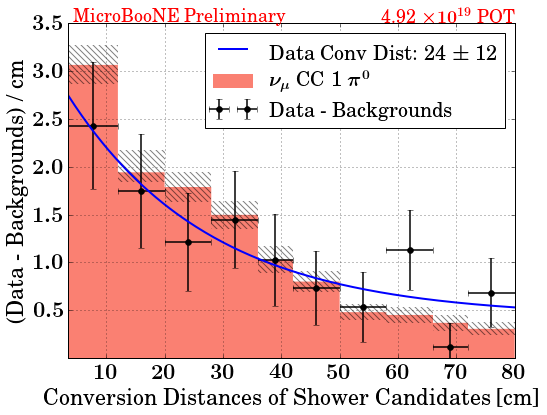

In [38]:
bins=[3.5,12,20,28,36,42,50,58,66,72,80] #,22,28,34,40,48,60] 
makeRLPlots('pi0_low_radL','pi0_high_radL',3.5,80,nbins=bins,xlabel='Conversion Distances of Shower Candidates [cm]')

In [19]:
name = 'singleshower'
stage = 'singleshower'

f = '/Volumes/UBooNEDataMCC8/MCC8_3/AnaFiles/MCBNBCos/BT_backgrounds_%s.root'%stage
on ='/Volumes/UBooNEDataMCC8/MCC8_3/AnaFiles/OnBeam/BT_backgrounds_%s.root'%stage
off='/Volumes/UBooNEDataMCC8/MCC8_3/AnaFiles/OffBeam/BT_backgrounds_%s.root'%stage

t = rn.root2array(f,treename='tree')
df = pd.DataFrame(t)

a = rn.root2array(on,treename='tree')
df0 = pd.DataFrame(a)

b = rn.root2array(off,treename='tree')
df1 = pd.DataFrame(b)

stage = 'singleshowerSignalonly'

In [20]:
all_but_sig_v = df.query('bkgd_id != 2')

dfa = df.query('pi0_low_origin != 2 and pi0_high_origin != 2')

cos_v = df.query('bkgd_id == 1 or pi0_low_origin == 2 or pi0_high_origin == 2')
cc1pi0_v = dfa.query('bkgd_id == 2')
nc1pi0_v = dfa.query('bkgd_id == 3')
multpi0_v = dfa.query('bkgd_id == 5')
cccex_v = dfa.query('bkgd_id == 8 ')
nu_EM_v = dfa.query('bkgd_id == 10 or ((bkgd_id ==12 or bkgd_id ==11) &\
                   (pi0_low_type == 1 or pi0_high_type == 1) )')

oth_v = dfa.query('bkgd_id == 0 or bkgd_id == 4 or\
                  bkgd_id == 6 or bkgd_id == 7 or bkgd_id == 9 or bkgd_id == 13 or \
                  ((bkgd_id ==12 or bkgd_id ==11) & pi0_low_type != 1 & pi0_high_type != 1)')

allbut_v = df.query('bkgd_id != 2 or pi0_low_origin == 2 or pi0_high_origin == 2')

In [21]:
print float(cos_v.shape[0])/df.shape[0]

#print cos_v.shape[0]

0.0276880479926


In [24]:
def makeSSRLPlots(var,xmin,xmax,nbins=[],xlabel='',pottitle='4.92e19 POT',unit='cm'):

    x_on, y_on = np.histogram(df0[var].values,bins=nbins,range=(xmin,xmax))
    x_off, y_off = np.histogram(df1[var].values,bins=nbins,range=(xmin,xmax))
    x_mc_sig, y_mc_sig = np.histogram(cc1pi0_v[var].values,bins=nbins,range=(xmin,xmax))
    x_mc_bkgd, y_mc_bkgd = np.histogram(all_but_sig_v[var].values,bins=nbins,range=(xmin,xmax))
    
    bins = (y_off[:-1] + y_off[1:])/2
    bin_width = bins[1]-bins[0]

    bnbcos_sig     = x_mc_sig * mc_to_onbeam 
    on_min_off_mc  = x_on - x_off * off_to_on - x_mc_bkgd * mc_to_onbeam
    
    err_mc_sig = np.sqrt(x_mc_sig) * mc_to_onbeam
    err_on = np.sqrt(x_on)
    err_off = np.sqrt(x_off) * off_to_on
    err_mc_bkgd = np.sqrt(x_mc_bkgd) * mc_to_onbeam
    err_on_off_mc = np.sqrt(err_on*err_on + err_off*err_off + err_mc_bkgd*err_mc_bkgd)

    sig_w = [ mc_to_onbeam for i in xrange(len(cc1pi0_v[var].values)) ] 
    
    df_v = [cc1pi0_v]; weights = [sig_w]
    
    for i in xrange(len(weights)):
        w = weights[i]
        for j in xrange(len(w)):
            if df_v[i][var].values[j] < bins[1] :
                w[j] *= (1./(nbins[1]-nbins[0]))
            elif df_v[i][var].values[j] >= nbins[1] and df_v[i][var].values[j]< nbins[2]:
                w[j] *= (1./(nbins[2]-nbins[1]))
            elif df_v[i][var].values[j] >= nbins[2] and df_v[i][var].values[j] < nbins[3]:
                w[j] *= (1./(nbins[3]-nbins[2]))
            elif df_v[i][var].values[j] >= nbins[3] and df_v[i][var].values[j] < nbins[4]:
                w[j] *= (1./(nbins[4]-nbins[3]))
            elif df_v[i][var].values[j] >= nbins[4] and df_v[i][var].values[j] < nbins[5]:
                w[j] *= (1./(nbins[5]-nbins[4]))
            elif df_v[i][var].values[j] >= nbins[5] and df_v[i][var].values[j] < nbins[6]:
                w[j] *= (1./(nbins[6]-nbins[5]))
            elif df_v[i][var].values[j] >= nbins[6] and df_v[i][var].values[j] < nbins[7]:
                w[j] *= (1./(nbins[7]-nbins[6]))
            elif df_v[i][var].values[j] >= nbins[7] and df_v[i][var].values[j] < nbins[8]:
                w[j] *= (1./(nbins[8]-nbins[7]))
            elif df_v[i][var].values[j] >= nbins[8] and df_v[i][var].values[j] < nbins[9]:
                w[j] *= (1./(nbins[9]-nbins[8]))
            elif df_v[i][var].values[j] >= nbins[9] and df_v[i][var].values[j] < nbins[10]:
                w[j] *= (1./(nbins[10]-nbins[9]))
            elif df_v[i][var].values[j] >= nbins[10] and df_v[i][var].values[j] < nbins[11]:
                w[j] *= (1./(nbins[11]-nbins[10]))
              
    lgd = 0
    labels_tst = ['$\\nu_{\mu}$ CC 1 $\pi^0$']; colors_tst = ['salmon'] 

    fig,ax = plt.subplots(figsize=(8,6))
    
    bar_bin_width = [nbins[i+1] - nbins[i] for i in xrange(len(nbins)-1) ]
    bar_bins = [(nbins[i+1] + nbins[i])/2 - (bar_bin_width[i])/2 for i in xrange(len(nbins)-1) ]
    
    data_bar_bin_width = [(nbins[i+1] - nbins[i])/2 for i in xrange(len(nbins)-1) ]

    new_weight = [ 1. / bar_bin_width[i] for i in xrange(len(bar_bin_width))]  
    
    out = ax.hist([cc1pi0_v[var].values],bins=nbins,label=labels_tst,color=colors_tst,ec='None',\
        range=(xmin,xmax),weights=weights,rwidth=bin_width,histtype='stepfilled')
    plt.bar(bar_bins,(err_mc_sig*2)*new_weight,width=bar_bin_width,bottom = (bnbcos_sig - err_mc_sig)*new_weight,\
        alpha=.5,  fill=False, linewidth=0,hatch='\\\\\\\\')
    plt.errorbar(bins,on_min_off_mc*new_weight,xerr=data_bar_bin_width,yerr=err_on_off_mc*new_weight,fmt='ko',label='Data - Backgrounds',markersize=6,lw=1.5)
    
    x_g = np.linspace(xmin,xmax,200)

    bins = (out[1][:-1] + out[1][1:])/2
    coeff, pcov = curve_fit(exp, bins, out[0], p0=([12.,.05,0.]))
    onesigma = np.sqrt(np.diag(pcov))
    #plt.plot(x_g, exp(x_g,*coeff), 'g-',label='MC Conv Dist: %i $\pm$ %i'%\
    #             ((1./coeff[1]),(1./coeff[1]**2*onesigma[1])),lw=2)

    coeff, pcov = curve_fit(exp, bins, on_min_off_mc*new_weight, p0=([12.,.05,0.]))
    onesigma = np.sqrt(np.diag(pcov))
    plt.plot(x_g, exp(x_g,*coeff), 'b-',label='Data Conv Dist: %i $\pm$ %i'%\
                 ((1./coeff[1]),(1./coeff[1]**2*onesigma[1])),lw=2)

    handles,labels = ax.get_legend_handles_labels()
    font = 22    
    lgd = plt.legend(handles=handles,fontsize=20,loc=0)#'upper left',bbox_to_anchor=(1,1),title=pottitle)
   
    plt.grid(True)
    plt.xlabel(xlabel,fontsize=font,weight='bold')
    plt.xticks(weight='bold')
    plt.ylim(0.001)
    #plt.ylim(-10,15)
    plt.ylabel('(Data - Backgrounds) / %s '%(unit),fontsize=font,weight='bold')
    
    plt.text(0.7,1.01,r'4.92 \textbf{$\times 10^{19}$} POT',weight='bold',color='r',fontsize=18,transform = ax.transAxes)
    plt.text(0.01,1.005,r'MicroBooNE Preliminary',weight='bold',color='r',fontsize=18,transform = ax.transAxes)

    plt.xlim(xmin,xmax)
    plt.savefig('Plots/Paper_%s_onoffseparate_%s.png'%(stage,var),bbox_extra_artists=(lgd,), bbox_inches='tight')

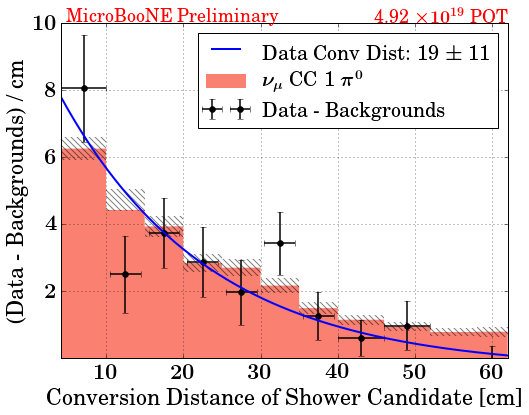

In [25]:
bins=[4.2,10,15,20,25,30,35,40,46,52,58,62]
makeSSRLPlots('gamma_RL',4.2,62,nbins=bins,xlabel='Conversion Distance of Shower Candidate [cm]')
#makeOnOffPlots('pi0_mass',4,46,nbins=bins,xlabel=r'$\mathrm{\sqrt{E_1 E_2 (1-cos\Theta_{12})} [MeV]}$',unit='MeV')